# Importation le dataset 

In [1]:
import pandas as pd
Test = pd.read_csv("indonesian.csv")

In [2]:
Test

,Category,Product Name,Location,Price,Overall Rating,Number Sold,Total Review,Customer Rating,Customer Review,Sentiment,Emotion,Translated_Review,Clean_Text
0,Computers and Laptops,Wireless Keyboard i8 Mini TouchPad Mouse 2.4G ...,Jakarta Utara,53500,4.9,5449,2369,5,Alhamdulillah berfungsi dengan baik. Packaging...,Positive,Happy,Thank God it works fine. Safe packaging. Fast ...,thank god work fine safe packaging fast friend...
1,Computers and Laptops,PAKET LISENSI WINDOWS 10 PRO DAN OFFICE 2019 O...,Kota Tangerang Selatan,72000,4.9,2359,1044,5,"barang bagus dan respon cepat, harga bersaing ...",Positive,Happy,"good stuff and fast response, competitive pric...",good stuff fast response competitive price others
2,Computers and Laptops,SSD Midasforce 128 Gb - Tanpa Caddy,Jakarta Barat,213000,5.0,12300,3573,5,"barang bagus, berfungsi dengan baik, seler ram...",Positive,Happy,"good item, works fine, friendly seller, fast d...",good item work fine friendly seller fast delivery
3,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,bagus sesuai harapan penjual nya juga ramah. t...,Positive,Happy,good as expected the seller is also friendly. ...,good expected seller also friendly thanks pelapak
4,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,"Barang Bagus, pengemasan Aman, dapat Berfungsi...",Positive,Happy,"Good Item, Safe packaging, can Work Well",good item safe packaging work well
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Automotive,"Parfum Mobil, Vania Coffee, Aroma Kopi, Parfum...",Jakarta Barat,30000,4.9,4016,1097,1,pesanan tidak sesuai. mmg sperti ini atau admi...,Negative,Fear,order is not correct. Is it like this or is it...,order not correct like admin not observant typ...
996,Automotive,"Parfum Mobil, Vania Coffee, Aroma Kopi, Parfum...",Jakarta Barat,30000,4.9,4016,1097,1,Wangi nya sma skali gak enak...kaya barang udh...,Negative,Fear,It doesn&#39;t smell good at all... it&#39;s l...,39 smell good 39 like item expired used car 39...
997,Automotive,Parfum mobil KOPI BALI ORIGINAL Pewangi kendar...,Jakarta Barat,2500,4.7,318600,7310,1,Barang Tidak sesuai deskripsi..!!!,Negative,Fear,Item does not match the description..!!!,item not match description
998,Automotive,Parfum mobil KOPI BALI ORIGINAL Pewangi kendar...,Jakarta Barat,2500,4.7,318600,7310,1,pesanan saya tdk dikirim. tlg direspon,Negative,Fear,my order was not sent. please respond,order not sent please respond


# Data preprocessing

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fchan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fchan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fchan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
def preprocess_text(text):
    
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"[^A-Za-z0-9 ]+", "", text)
    text = re.sub(r"\n", " ", text)  
    tokens = nltk.word_tokenize(text.lower())
   
    stop_words = set(stopwords.words('english'))
    stop_words.remove('not')
    stop_words.remove('no')
    stop_words.remove('but')
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    preprocessed_tokens = []

    for token in filtered_tokens:
            lemma = lemmatizer.lemmatize(token)  # Lemmatize verbs
            preprocessed_tokens.append(lemma)

    preprocessed_text = ' '.join(preprocessed_tokens)
    return preprocessed_text

In [8]:
from tqdm import tqdm

tqdm.pandas()

Test['preprocessed_text'] = Test['Translated_Review'].progress_apply(preprocess_text)

100%|██████████| 1000/1000 [00:00<00:00, 1961.59it/s]


# Mise en place du modèle 

In [13]:
#Utilisation du modèle EmoRoberta pour le modèle d'analyse d'émotions

import pandas as pd
import tensorflow as tf
from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification, pipeline
from tqdm import tqdm

tokenizer = RobertaTokenizerFast.from_pretrained("arpanghoshal/EmoRoBERTa")
model = TFRobertaForSequenceClassification.from_pretrained("arpanghoshal/EmoRoBERTa")

emotion = pipeline('sentiment-analysis', model='arpanghoshal/EmoRoBERTa')


def classify_emotion(row):
    text = str(row["preprocessed_text"])
    rating = row["Customer Rating"] 
    
    #Tokenization
    
    tokens = tokenizer.encode_plus(text, truncation=True, padding=True, max_length=512, return_tensors="tf")
    
    result = model(tokens.input_ids, attention_mask=tokens.attention_mask)
    emotion_scores = result.logits[0]  
    
    emotions = model.config.id2label
    emotions = [emotions[i] for i in range(len(emotions))]
    
    probabilities = tf.nn.softmax(emotion_scores).numpy().tolist()
    
    #Prise en compte des ratings pour changer les probabilités 
    
    if rating < 3:
        probabilities = [p * 1.2 if e in ["anger", "annoyance", "confusion", "disappointment", "disapproval", "disgust", "embarrassment", "fear", "grief", "nervousness", "remorse", "sadness"] else p for e, p in zip(emotions, probabilities)]
    elif rating > 3:
        probabilities = [p * 1.2 if e in ["admiration", "amusement", "approval", "caring", "curiosity", "desire", "excitement", "gratitude", "joy", "love", "optimism", "pride", "relief", "surprise"] else p for e, p in zip(emotions, probabilities)]
    else:
        probabilities = [p * 1.2 if e == "neutral" else p for e, p in zip(emotions, probabilities)]
    
    desired_emotions = ["love", "approval", "disapproval", "joy", "disgust", "disappointment"]
    desired_probabilities = [p for e, p in zip(emotions, probabilities) if e in desired_emotions]
    desired_emotions = [e for e in emotions if e in desired_emotions]
    
    highest_emotion_index = desired_probabilities.index(max(desired_probabilities))
    highest_emotion = desired_emotions[highest_emotion_index]
    
    return highest_emotion


tqdm.pandas(desc="Processing rows")
Test["highest_emotion"] = Test.progress_apply(classify_emotion, axis=1)
Test


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
Processing rows: 100%|██████████| 1000/1000 [03:19<00:00,  5.02it/s]


,Category,Product Name,Location,Price,Overall Rating,Number Sold,Total Review,Customer Rating,Customer Review,Sentiment,Emotion,Translated_Review,Clean_Text,preprocessed_text,highest_emotion
0,Computers and Laptops,Wireless Keyboard i8 Mini TouchPad Mouse 2.4G ...,Jakarta Utara,53500,4.9,5449,2369,5,Alhamdulillah berfungsi dengan baik. Packaging...,Positive,Happy,Thank God it works fine. Safe packaging. Fast ...,thank god work fine safe packaging fast friend...,thank god work fine safe packaging fast friend...,approval
1,Computers and Laptops,PAKET LISENSI WINDOWS 10 PRO DAN OFFICE 2019 O...,Kota Tangerang Selatan,72000,4.9,2359,1044,5,"barang bagus dan respon cepat, harga bersaing ...",Positive,Happy,"good stuff and fast response, competitive pric...",good stuff fast response competitive price others,good stuff fast response competitive price others,approval
2,Computers and Laptops,SSD Midasforce 128 Gb - Tanpa Caddy,Jakarta Barat,213000,5.0,12300,3573,5,"barang bagus, berfungsi dengan baik, seler ram...",Positive,Happy,"good item, works fine, friendly seller, fast d...",good item work fine friendly seller fast delivery,good item work fine friendly seller fast delivery,approval
3,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,bagus sesuai harapan penjual nya juga ramah. t...,Positive,Happy,good as expected the seller is also friendly. ...,good expected seller also friendly thanks pelapak,good expected seller also friendly thanks pelapak,approval
4,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,"Barang Bagus, pengemasan Aman, dapat Berfungsi...",Positive,Happy,"Good Item, Safe packaging, can Work Well",good item safe packaging work well,good item safe packaging work well,approval
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Automotive,"Parfum Mobil, Vania Coffee, Aroma Kopi, Parfum...",Jakarta Barat,30000,4.9,4016,1097,1,pesanan tidak sesuai. mmg sperti ini atau admi...,Negative,Fear,order is not correct. Is it like this or is it...,order not correct like admin not observant typ...,order not correct like admin not observant typ...,disapproval
996,Automotive,"Parfum Mobil, Vania Coffee, Aroma Kopi, Parfum...",Jakarta Barat,30000,4.9,4016,1097,1,Wangi nya sma skali gak enak...kaya barang udh...,Negative,Fear,It doesn&#39;t smell good at all... it&#39;s l...,39 smell good 39 like item expired used car 39...,doesn39t smell good it39s like item expired us...,disapproval
997,Automotive,Parfum mobil KOPI BALI ORIGINAL Pewangi kendar...,Jakarta Barat,2500,4.7,318600,7310,1,Barang Tidak sesuai deskripsi..!!!,Negative,Fear,Item does not match the description..!!!,item not match description,item not match description,disapproval
998,Automotive,Parfum mobil KOPI BALI ORIGINAL Pewangi kendar...,Jakarta Barat,2500,4.7,318600,7310,1,pesanan saya tdk dikirim. tlg direspon,Negative,Fear,my order was not sent. please respond,order not sent please respond,order not sent please respond,approval


# Plot des emotions

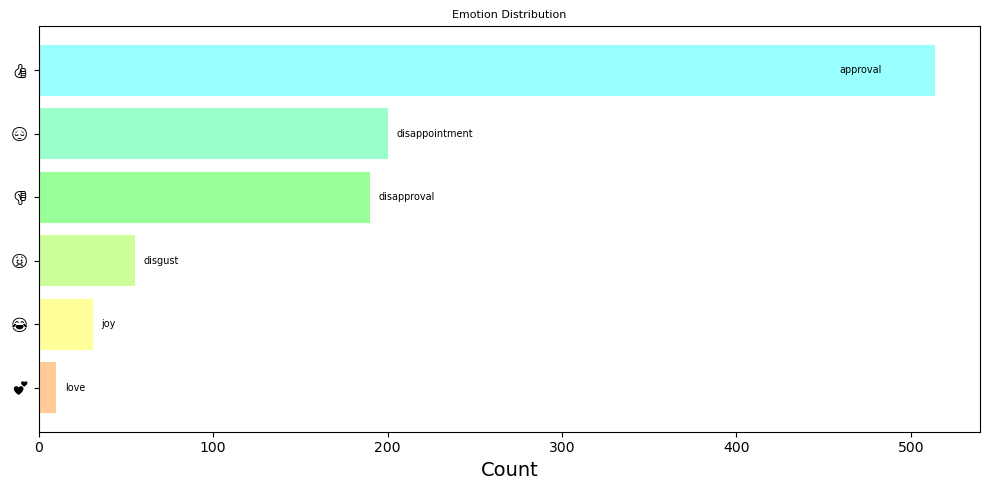

In [14]:
import matplotlib.pyplot as plt

emotion_emojis = {
    "admiration": "😊",
    "approval": "👍",
    "joy": "😂",
    "love": "💕",
    "neutral": "😐",
    "disapproval": "👎",
    "disgust": "🤢",
    "disappointment": "😔",
    "sadness": "😢",
    "annoyance": "😠",
    "embarrassment": "😳"
}


emotion_counts = Test["highest_emotion"].value_counts()


emotion_counts = emotion_counts.sort_values(ascending=True)


colors = ["#FFCC99", "#FFFF99", "#CCFF99", "#99FF99", "#99FFCC", "#99FFFF"]

fig, ax = plt.subplots(figsize=(10, 5))
emojis = [emotion_emojis.get(emotion, "") for emotion in emotion_counts.index]
ax.barh(emotion_counts.index, emotion_counts, color=colors)
ax.set_xlabel("Count", fontsize=14)
ax.set_title("Emotion Distribution", fontsize=8)
ax.set_yticks(range(len(emotion_counts)))
ax.set_yticklabels(emojis, fontname="Segoe UI Emoji", fontsize= 10)


for i, emotion in enumerate(emotion_counts.index):
    count = emotion_counts[emotion]
    if count < max(emotion_counts):
        ax.text(count + 5, i, f"{emotion}", va='center', fontsize=7)
    else:
        ax.text(count - 55, i, f"{emotion}", va='center', fontsize=7)

plt.tight_layout()
plt.show()
